# 0. IMPORTS

## 0.1. Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

## 0.2. Loading data

In [3]:
#url = 'https://challenge-data-science-3ed.s3.amazonaws.com/Telco-Customer-Churn.json'
#df = pd.read_json(url)
df = pd.read_json('Telco-Customer-Churn.json')

## 0.3. Dicionário de dados

Nome | Descrição
--|--
customerID | número de identificação único de cada cliente
Churn | se o cliente deixou ou não a empresa 
gender | gênero (masculino e feminino) 
SeniorCitizen | informação sobre um cliente ter ou não idade igual ou maior que 65 anos 
Partner |  se o cliente possui ou não um parceiro ou parceira
Dependents | se o cliente possui ou não dependentes
tenure |  meses de contrato do cliente
PhoneService | assinatura de serviço telefônico 
MultipleLines | assisnatura de mais de uma linha de telefone 
InternetService | assinatura de um provedor internet 
OnlineSecurity | assinatura adicional de segurança online 
OnlineBackup | assinatura adicional de backup online 
DeviceProtection | assinatura adicional de proteção no dispositivo 
TechSupport | assinatura adicional de suporte técnico, menos tempo de espera
StreamingTV | assinatura de TV a cabo 
StreamingMovies | assinatura de streaming de filmes 
Contract | tipo de contrato
PaperlessBilling | se o cliente prefere receber online a fatura
PaymentMethod | forma de pagamento
Charges.Monthly | total de todos os serviços do cliente por mês
Charges.Total | total gasto pelo cliente

## 0.3. Helper functions

In [4]:
def rename_columns(cols):
    cols = list(map(lambda x: inflection.titleize(x), cols))
    cols = list(map(lambda x: x.replace(" ", ""), cols))
    cols = list(map(lambda x: x.replace(".", ""), cols))
    cols = list(map(lambda x: inflection.underscore(x), cols))
    return cols

def tab_unique(df):
    tab_unicos = pd.DataFrame(df.nunique())
    tab_unicos.columns= ['count']
    tab_unicos['content'] = df.apply(lambda x: x.unique())
    return tab_unicos

## 0.4. Identidade Visual

In [5]:
paleta_personalizada = {
    'black': '#171821',
    'purple': '#872b95',
    'orange': '#ff7131',
    'pink': '#fe3d67'
}

# 1. DATA DESCRIPTION

In [6]:
df1 = df.copy()

## 1.1. Normalize Columns

In [7]:
# Normalizar colunas com dicionários aninhados
columns_to_normalize = ['customer', 'phone', 'internet', 'account']
for col in columns_to_normalize:
    df1 = pd.concat([df1.drop([col], axis=1), pd.json_normalize(df1[col])], axis=1)
df1.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


## 1.2. Rename Columns

In [8]:
df1.columns = rename_columns(df1.columns)
df1.columns

Index(['customer', 'churn', 'gender', 'senior_citizen', 'partner',
       'dependents', 'tenure', 'phone_service', 'multiple_lines',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'contract', 'paperless_billing', 'payment_method', 'charges_monthly',
       'charges_total'],
      dtype='object')

## 1.3. Data Dimensions

In [9]:
print('Quantidade de linha: {:,}'.format(df1.shape[0]))
print('Quantidade de colunas: {:,}'.format(df1.shape[1]))

Quantidade de linha: 7,267
Quantidade de colunas: 21


## 1.4. Data Types

In [10]:
df1.dtypes

customer              object
churn                 object
gender                object
senior_citizen         int64
partner               object
dependents            object
tenure                 int64
phone_service         object
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
contract              object
paperless_billing     object
payment_method        object
charges_monthly      float64
charges_total         object
dtype: object

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer           7267 non-null   object 
 1   churn              7267 non-null   object 
 2   gender             7267 non-null   object 
 3   senior_citizen     7267 non-null   int64  
 4   partner            7267 non-null   object 
 5   dependents         7267 non-null   object 
 6   tenure             7267 non-null   int64  
 7   phone_service      7267 non-null   object 
 8   multiple_lines     7267 non-null   object 
 9   internet_service   7267 non-null   object 
 10  online_security    7267 non-null   object 
 11  online_backup      7267 non-null   object 
 12  device_protection  7267 non-null   object 
 13  tech_support       7267 non-null   object 
 14  streaming_tv       7267 non-null   object 
 15  streaming_movies   7267 non-null   object 
 16  contract           7267 

## 1.5. Check NA's

In [12]:
# Aparentemente não há NA's, mas é necessário analisar mais de perto cada feature
df1.isna().sum()

customer             0
churn                0
gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
charges_monthly      0
charges_total        0
dtype: int64

In [13]:
# Nota-se que existem Na's:
# > churn == ' '
# > na terceira opção de algumas features de 'Yes' ou 'No' 
# > charges_total == ' '
tab_unique(df1)

,count,content
customer,7267,"[0002-ORFBO, 0003-MKNFE, 0004-TLHLJ, 0011-IGKF..."
churn,3,"[No, Yes, ]"
gender,2,"[Female, Male]"
senior_citizen,2,"[0, 1]"
partner,2,"[Yes, No]"
dependents,2,"[Yes, No]"
tenure,73,"[9, 4, 13, 3, 71, 63, 7, 65, 54, 72, 5, 56, 34..."
phone_service,2,"[Yes, No]"
multiple_lines,3,"[No, Yes, No phone service]"
internet_service,3,"[DSL, Fiber optic, No]"


In [14]:
df1['payment_method'].unique()

array(['Mailed check', 'Electronic check', 'Credit card (automatic)',
       'Bank transfer (automatic)'], dtype=object)

## 1.6. Check duplicated 

In [116]:
df1.duplicated().sum()

0

# 2. FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

In [16]:
df2_encoded = df2.copy()

encode_columns = ['phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 
                  'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

for col in encode_columns:
    df2_encoded[col] = df2_encoded[col].map(lambda x: 0 if 'No' in str(x) else 1)

df2_encoded['num_services'] = df2_encoded[encode_columns].sum(axis=1)

In [17]:
df2['num_services'] = df2_encoded['num_services']

# 3. FILTRAGEM DE VARIÁVEIS

In [18]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

### 3.1.1. Remover linhas com churn vazio

In [19]:
# Precisamos remover dados com churn vazio. os vazios representam 3,08% dos dados.
churn_vazios = df3['churn'].value_counts().to_frame()
churn_vazios.columns = ['count']
churn_vazios['%'] = round(df3['churn'].value_counts(normalize=True).sort_values() * 100, 2)
churn_vazios

,count,%
No,5174,71.20
Yes,1869,25.72
,224,3.08


In [20]:
# Selecionar as linhas com churn vazio
churn_vazio = df3.query('churn == ""').index

# Deletar essas linhas
df3.drop(churn_vazio, axis=0, inplace=True)

# Validar alterações
df3['churn'].unique()

array(['No', 'Yes'], dtype=object)

In [21]:
# Resetar o index e validar modificações
df3 = df3.reset_index(drop=True)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer           7043 non-null   object 
 1   churn              7043 non-null   object 
 2   gender             7043 non-null   object 
 3   senior_citizen     7043 non-null   int64  
 4   partner            7043 non-null   object 
 5   dependents         7043 non-null   object 
 6   tenure             7043 non-null   int64  
 7   phone_service      7043 non-null   object 
 8   multiple_lines     7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  contract           7043 

### 3.1.2. Substituir a terceira opção por 'No'

In [22]:
col_yes_no = ['multiple_lines', 'online_security', 'online_backup', 
              'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

for col in col_yes_no:
    df3[col] = df3[col].apply(lambda x: 'No' if x not in ['Yes', 'No'] else x)

In [23]:
for col in col_yes_no:
    print(col, df3[col].unique())

multiple_lines ['No' 'Yes']
online_security ['No' 'Yes']
online_backup ['Yes' 'No']
device_protection ['No' 'Yes']
tech_support ['Yes' 'No']
streaming_tv ['Yes' 'No']
streaming_movies ['No' 'Yes']


### 3.1.3. Tratar linhas com 'charges_total' vazio

In [24]:
# Ao tratar a coluna 'charges_total' tb será necessário tratar 'tenure'
df3.loc[df3['charges_total'] == ' ', ['tenure', 'contract', 'charges_monthly', 'charges_total']]

,tenure,contract,charges_monthly,charges_total
945,0,Two year,56.05,
1731,0,Two year,20.00,
1906,0,Two year,61.90,
2025,0,One year,19.70,
2176,0,Two year,20.25,
2250,0,Two year,25.35,
2855,0,Two year,73.35,
3052,0,Two year,25.75,
3118,0,Two year,52.55,
4054,0,Two year,80.85,


In [25]:
idx1 = df3.loc[(df3['charges_total'] == ' ') & (df3['contract'] == 'One year'), ['contract', 'charges_monthly', 'charges_total']].index
idx2 = df3.loc[(df3['charges_total'] == ' ') & (df3['contract'] == 'Two year'), ['contract', 'charges_monthly', 'charges_total']].index

In [26]:
df3.loc[idx1, 'charges_total'] = df3['charges_monthly'] * 12
df3.loc[idx2, 'charges_total'] = df3['charges_monthly'] * 24

In [27]:
df3.loc[idx1, ['tenure', 'contract', 'charges_monthly', 'charges_total']]

,tenure,contract,charges_monthly,charges_total
2025,0,One year,19.7,236.4


In [28]:
df3.loc[idx2, ['tenure', 'contract', 'charges_monthly', 'charges_total']]

,tenure,contract,charges_monthly,charges_total
945,0,Two year,56.05,1345.2
1731,0,Two year,20.00,480.0
1906,0,Two year,61.90,1485.6
2176,0,Two year,20.25,486.0
2250,0,Two year,25.35,608.4
2855,0,Two year,73.35,1760.4
3052,0,Two year,25.75,618.0
3118,0,Two year,52.55,1261.2
4054,0,Two year,80.85,1940.4
5433,0,Two year,19.85,476.4


In [29]:
df3['charges_total'] = df3['charges_total'].astype(np.float64)

### 3.1.4. Tratar linhas com 'tenure' igual a 0

In [30]:
idx = df3.loc[df3['tenure'] == 0, ['tenure', 'contract', 'charges_monthly', 'charges_total']].index

In [31]:
df3.loc[idx, 'tenure'] = np.ceil(df3['charges_total'] / df3['charges_monthly']).astype(np.int64)

In [32]:
df3.loc[idx, ['tenure', 'contract', 'charges_monthly', 'charges_total']]

,tenure,contract,charges_monthly,charges_total
945,24,Two year,56.05,1345.2
1731,24,Two year,20.00,480.0
1906,24,Two year,61.90,1485.6
2025,12,One year,19.70,236.4
2176,24,Two year,20.25,486.0
2250,25,Two year,25.35,608.4
2855,24,Two year,73.35,1760.4
3052,24,Two year,25.75,618.0
3118,24,Two year,52.55,1261.2
4054,24,Two year,80.85,1940.4


## 3.2. Seleção das Colunas

### 3.2.1. Remover coluna customer

In [33]:
df3.drop('customer', axis=1, inplace=True)

### 3.2.2. Converter senior_citizen em categórico ('Yes', 'No')

In [34]:
# Converter senior_citizen em categórico ('Yes', 'No')
df3['senior_citizen'] = df3['senior_citizen'].map({0: 'No', 1: 'Yes'})

In [35]:
tab_unique(df3)

,count,content
churn,2,"[No, Yes]"
gender,2,"[Female, Male]"
senior_citizen,2,"[No, Yes]"
partner,2,"[Yes, No]"
dependents,2,"[Yes, No]"
tenure,72,"[9, 4, 13, 3, 71, 63, 7, 65, 54, 72, 5, 56, 34..."
phone_service,2,"[Yes, No]"
multiple_lines,2,"[No, Yes]"
internet_service,3,"[DSL, Fiber optic, No]"
online_security,2,"[No, Yes]"


# 4. EXPLORATORY DATA ANALYSIS (EDA)

In [36]:
df4 = df3.copy()

In [37]:
# Separar os tipos de dados categóricos dos numéricos
df_num = df4.select_dtypes(include = ['int64', 'float64'])
df_cat = df4.select_dtypes(exclude = ['int64', 'float64'])

## 4.1. Análise Univariada

* Como são as variáveis? 
* Estatística descritiva.

### 4.1.1. Response Variable

In [38]:
df4.columns

Index(['churn', 'gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'charges_monthly', 'charges_total', 'num_services'],
      dtype='object')

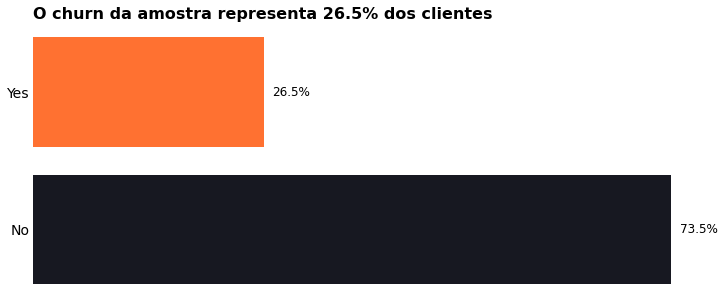

In [39]:
col = 'churn'

aux = df4[col].value_counts(normalize=True).to_frame() * 100
aux = aux.sort_values(col, ascending=False)

cores = [paleta_personalizada['orange'] if tipo == aux[col].idxmin() else 
         paleta_personalizada['black'] for tipo in aux.index]

fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(aux.index, aux[col], color=cores)

ax.yaxis.set_tick_params(labelsize=14)
ax.set_title(f'O churn da amostra representa {aux[col].min():.1f}% dos clientes', 
             loc='left', fontsize=16, fontweight='bold')

for i, v in enumerate(aux[col]):
    formatted_value = '{:.1f}%'.format(v)
    ax.text(v + 1, i, formatted_value, color='black', fontsize=12, ha='left', va='center')
    
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

plt.show()

### 4.1.2. Numerical Variable

Nome | Descrição
--|--
tenure |  meses de contrato do cliente
Charges.Monthly | total de todos os serviços do cliente por mês
Charges.Total | total gasto pelo cliente

In [40]:
# Incluir: Range, kurtosis, skew e std 
num_describe = df_num.describe().T
num_describe['range'] = pd.DataFrame(df_num.apply(lambda x: x.max() - x.min()))
num_describe['skew'] = pd.DataFrame(df_num.apply(lambda x: x.skew()))
num_describe['kurtosis'] = pd.DataFrame(df_num.apply(lambda x: x.kurtosis()))
num_describe

,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
tenure,7043.0,32.407071,24.529292,1.00,9.0,29.00,55.00,72.00,71.0,0.239486,-1.385484
charges_monthly,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75,100.5,-0.220524,-1.257260
charges_total,7043.0,2281.253259,2265.703526,18.80,401.9,1396.25,3786.60,8684.80,8666.0,0.963745,-0.227068
num_services,7043.0,4.146244,2.312720,1.00,2.0,4.00,6.00,9.00,8.0,0.221909,-1.003354


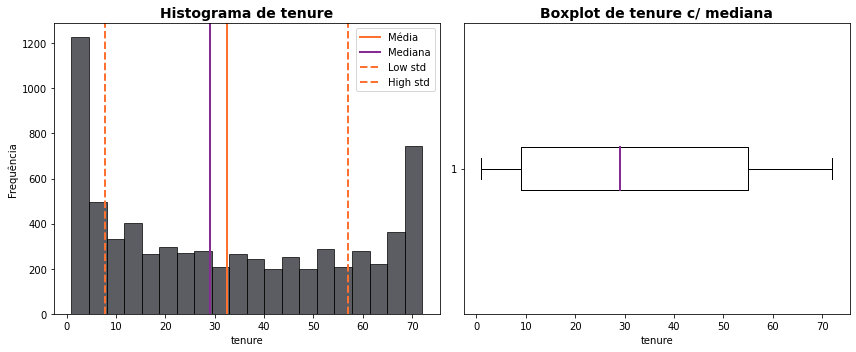

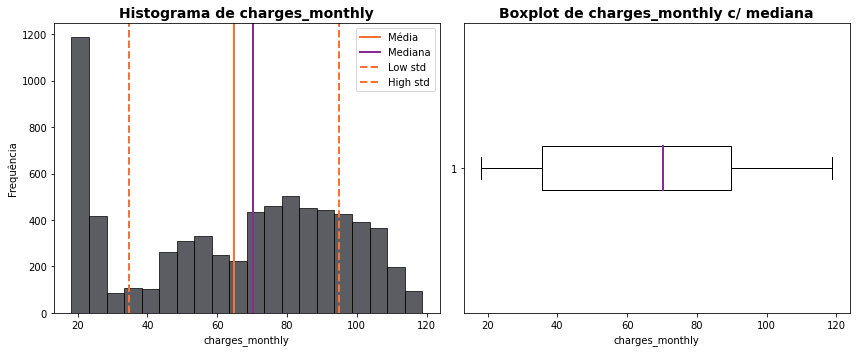

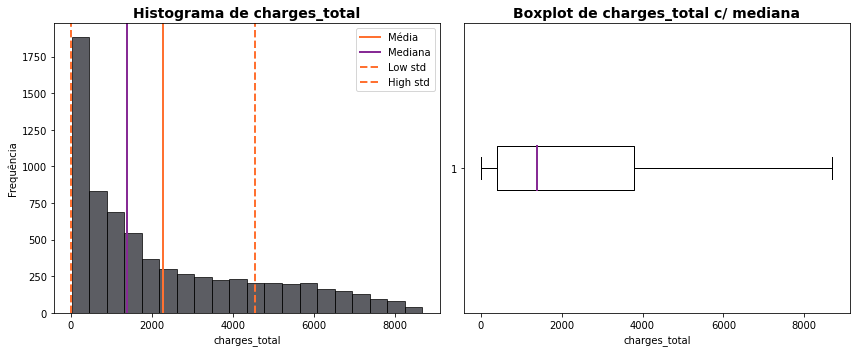

In [41]:
def grafics_num_attribute(df, col):
    # Calcular a média e a mediana
    mean_value = np.mean(df[col])
    median_value = np.median(df[col])
    std_low = mean_value - np.std(df[col])
    std_high = mean_value + np.std(df[col])

    # Criação dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plotagem do histograma no primeiro subplot
    ax1.hist(df[col], bins=20, edgecolor='black', alpha=0.7, color=paleta_personalizada['black'])
    ax1.axvline(mean_value, color=paleta_personalizada['orange'], linewidth=2, label='Média')
    ax1.axvline(median_value, color=paleta_personalizada['purple'], linewidth=2, label='Mediana')
    ax1.axvline(std_low, color=paleta_personalizada['orange'], linestyle='dashed', linewidth=2, label='Low std')
    ax1.axvline(std_high, color=paleta_personalizada['orange'], linestyle='dashed', linewidth=2, label='High std')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Frequência')
    ax1.set_title(f'Histograma de {col}', fontsize=14, fontweight='bold')
    ax1.legend()

    # Plotagem do boxplot no segundo subplot
    ax2.boxplot(df[col], vert=False, medianprops={'color': paleta_personalizada['purple'], 'linewidth': 2})
    ax2.set_xlabel(col)
    ax2.set_title(f'Boxplot de {col} c/ mediana', fontsize=14, fontweight='bold')

    # Ajustar espaçamento entre os subplots
    plt.tight_layout()

    # Exibir os subplots
    plt.show()

# Chamar a função para cada atributo
for col in ['tenure', 'charges_monthly', 'charges_total']:
    grafics_num_attribute(df_num, col)

### 4.1.3. Categorical Variable

In [42]:
df_cat.columns

Index(['churn', 'gender', 'senior_citizen', 'partner', 'dependents',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method'],
      dtype='object')

#### 4.1.3.1. Variáveis relativas ao cliente 

Variáveis relativas ao cliente | Descrição
--|--
gender | gênero (masculino e feminino) 
SeniorCitizen | informação sobre um cliente ter ou não idade igual ou maior que 65 anos 
Partner |  se o cliente possui ou não um parceiro ou parceira
Dependents | se o cliente possui ou não dependentes
PaperlessBilling | se o cliente prefere receber online a fatura

In [43]:
df_cat['gender'].value_counts(normalize=True) * 100

Male      50.47565
Female    49.52435
Name: gender, dtype: float64

In [44]:
customer_cols = ['gender', 'senior_citizen', 'partner', 'dependents', 'paperless_billing']
df_customer = df_cat.loc[:, customer_cols].copy()

In [45]:
# Transformar em internet_service em binário para visualização generalizada dos serviços assinados
df_customer['gender'] = df_customer['gender'].map(lambda x: 'Yes' if x == 'Female' else 'No')
df_customer['gender'].unique()

array(['Yes', 'No'], dtype=object)

In [46]:
# Constroi tabela de frequência relativa das features
customer_relative_frequency = pd.DataFrame()
for col in list(df_customer.columns):
    customer_relative_frequency[col] = df_customer[col].value_counts(normalize=True) * 100

mapa = {'gender'            : 'É do sexo masculino',
        'senior_citizen'    : 'Tem menos de 65 anos',
        'partner'           : 'Não possui parceiro(a)',
        'dependents'        : 'Não Possui dependentes',
        'paperless_billing' : 'Prefere receber a fatura impressa' 
       }

customer_relative_frequency = customer_relative_frequency.rename(columns = mapa)
customer_relative_frequency = customer_relative_frequency.T
customer_relative_frequency.columns = ['No', 'Yes']

customer_relative_frequency_sorted = customer_relative_frequency.sort_values(by='No', ascending=True)
customer_relative_frequency_sorted

,No,Yes
Prefere receber a fatura impressa,40.778078,59.221922
É do sexo masculino,50.475650,49.524350
Não possui parceiro(a),51.696720,48.303280
Não Possui dependentes,70.041176,29.958824
Tem menos de 65 anos,83.785319,16.214681


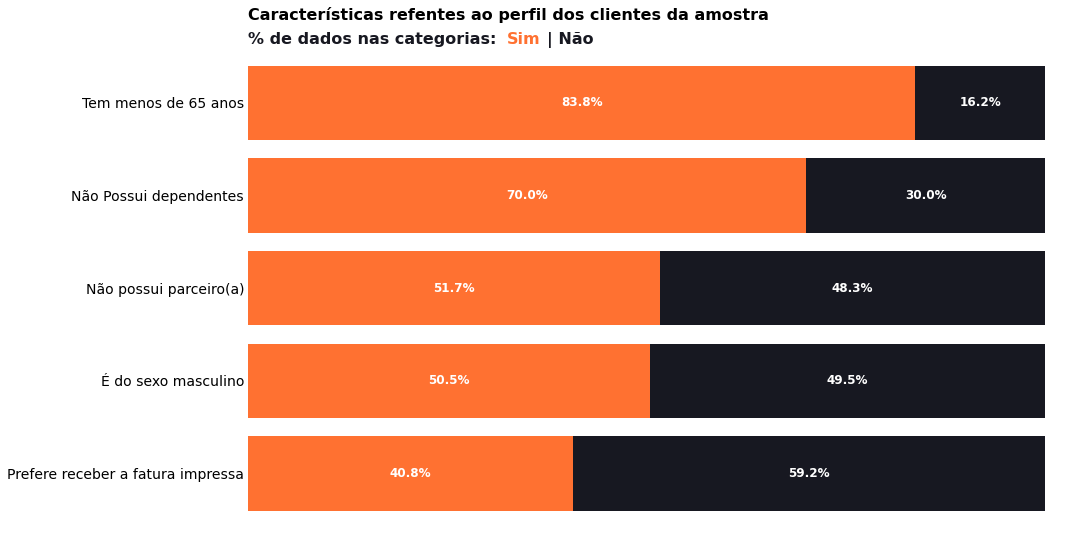

In [47]:
col_left  = 'No'
col_right = 'Yes'
aux = customer_relative_frequency_sorted

# Crie um gráfico de barras empilhadas horizontal
fig, ax = plt.subplots(figsize=(15, 9))

# Primeira camada (col_left)
ax.barh(aux.index, aux[col_left], color=paleta_personalizada['orange'])

# Crie o texto
ax.set_title('Características refentes ao perfil dos clientes da amostra\n', 
             loc='left', fontsize=16, fontweight='bold')

# Segunda camada (col_right)
ax.barh(aux.index, aux[col_right], left=aux[col_left], color=paleta_personalizada['black'])

# Adicionar col_left com uma cor diferente
ax.text(0, 1, '% de dados nas categorias:         | Não', 
        color=paleta_personalizada['black'], fontsize=16, fontweight='bold', transform=ax.transAxes)

ax.text(0.31, 1, 'Sim', color=paleta_personalizada['orange'], 
        fontsize=16, fontweight='bold', transform=ax.transAxes)

ax.legend(loc='upper center', ncol=2, frameon=False, labels=[]).set_visible(False)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.yaxis.set_tick_params(labelsize=14)
    
# Adicionar os valores dentro das barras
for c in ax.containers:
    labels = [f'{w:0.1f}%' if (w := v.get_width()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', padding=0.3, color='w', fontsize=12, fontweight='bold')
    
plt.show();

#### 4.1.3.2. Variáveis relativas ao pagamento

Variáveis relativas ao pagamento | Descrição
--|--
Contract | tipo de contrato
PaymentMethod | forma de pagamento

In [48]:
payments_cols = ['contract', 'payment_method']
df_payments = df_cat.loc[:, payments_cols].copy()
tab_unique(df_payments)

,count,content
contract,3,"[One year, Month-to-month, Two year]"
payment_method,4,"[Mailed check, Electronic check, Credit card (..."


In [49]:
df_payments['contract'].value_counts(normalize=True).to_frame().sort_values(by='contract', ascending=False) *100

,contract
Month-to-month,55.019168
Two year,24.066449
One year,20.914383


In [50]:
df_payments['payment_method'].value_counts(normalize=True).to_frame().sort_values(by='payment_method', ascending=False) *100

,payment_method
Electronic check,33.579441
Mailed check,22.887974
Bank transfer (automatic),21.922476
Credit card (automatic),21.610109


#### 4.1.3.3. Variáveis relativas aos serviços contratados

Variáveis relativas aos serviços contratados | Descrição
--|--
PhoneService | assinatura de serviço telefônico 
MultipleLines | assisnatura de mais de uma linha de telefone 
InternetService | assinatura de um provedor internet 
OnlineSecurity | assinatura adicional de segurança online 
OnlineBackup | assinatura adicional de backup online 
DeviceProtection | assinatura adicional de proteção no dispositivo 
TechSupport | assinatura adicional de suporte técnico, menos tempo de espera
StreamingTV | assinatura de TV a cabo 
StreamingMovies | assinatura de streaming de filmes 

In [51]:
service_cols = ['phone_service', 'multiple_lines', 'internet_service',
                'online_security', 'online_backup', 'device_protection', 'tech_support',
                'streaming_tv', 'streaming_movies']

df_service = df_cat.loc[:, service_cols].copy()

In [52]:
# Transformar em internet_service em binário para visualização generalizada dos serviços assinados
df_service['internet_service'] = df_service['internet_service'].map(lambda x: 'Yes' if x != 'No' else x)
df_service['internet_service'].unique()

array(['Yes', 'No'], dtype=object)

In [53]:
# Constroi tabela de frequência relativa das features
service_relative_frequency = pd.DataFrame()
for col in list(df_service.columns):
    service_relative_frequency[col] = df_service[col].value_counts(normalize=True) * 100

mapa = {'phone_service'     : 'Serviço telefônico',
        'multiple_lines'    : '>= 2 linha de telefone',
        'internet_service'  : 'Serviço de internet',
        'online_security'   : 'Adicional de segurança online',
        'online_backup'     : 'Adicional de backup online',
        'device_protection' : 'Adicional de proteção no dispositivo',
        'tech_support'      : 'Adicional de suporte técnico',
        'streaming_tv'      : 'Assinatura de TV a cabo',
        'streaming_movies'  : 'Assinatura de streaming de filmes'
       }

service_relative_frequency = service_relative_frequency.rename(columns = mapa)
service_relative_frequency = service_relative_frequency.T

service_relative_frequency_sorted = service_relative_frequency.sort_values(by='Yes', ascending=True)

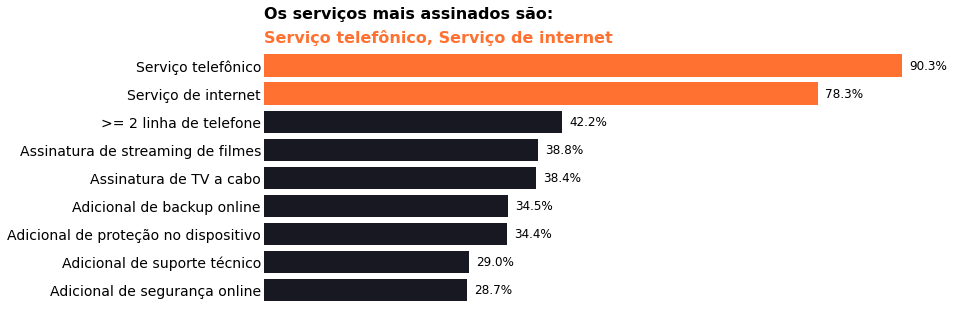

In [54]:
col = 'Yes'
aux = service_relative_frequency_sorted

# Defina a lista de cores
cores = [paleta_personalizada['orange'] if v > 50 else paleta_personalizada['black'] for v in aux[col]]

# Crie o texto
texto = ', '.join([aux.index[i] for i, v in reversed(list(enumerate(aux[col]))) if v > 50])

fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(aux.index, aux[col], color=cores)
ax.set_title(f'Os serviços mais assinados são:\n', 
             loc='left', fontsize=16, fontweight='bold')

ax.text(0, 1, texto, 
        color=paleta_personalizada['orange'], fontsize=16, fontweight='bold', transform=ax.transAxes)

for i, v in enumerate(aux[col]):
    formatted_value = '{:.1f}%'.format(v)
    ax.text(v + 1, i, formatted_value, color='black', fontsize=12, ha='left', va='center')
    
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.yaxis.set_tick_params(labelsize=14)

plt.show()

## 4.2. Análise Bivariada

* Como as variáveis impactam no fenômeno?
* Qual a força deste impacto?
* Levantamento de hipóteses.

### 4.2.1. Numerical Variable

In [55]:
df_num.columns

Index(['tenure', 'charges_monthly', 'charges_total', 'num_services'], dtype='object')

In [56]:
df_num_churn_yes = df4.loc[df4['churn'] == 'Yes', ['churn', 'tenure', 'charges_monthly', 'charges_total']].reset_index(drop=True)
df_num_churn_yes

,churn,tenure,charges_monthly,charges_total
0,Yes,4,73.90,280.85
1,Yes,13,98.00,1237.85
2,Yes,3,83.90,267.40
3,Yes,45,62.70,2791.50
4,Yes,1,25.10,25.10
...,...,...,...,...
1864,Yes,21,96.80,2030.30
1865,Yes,9,83.85,790.15
1866,Yes,1,70.15,70.15
1867,Yes,4,20.95,85.50


In [57]:
num_describe_churn_yes = df_num_churn_yes.describe().T
num_describe_churn_yes['range'] = pd.DataFrame(df_num.apply(lambda x: x.max() - x.min()))
num_describe_churn_yes['skew'] = pd.DataFrame(df_num.apply(lambda x: x.skew()))
num_describe_churn_yes['kurtosis'] = pd.DataFrame(df_num.apply(lambda x: x.kurtosis()))
num_describe_churn_yes

,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
tenure,1869.0,17.979133,19.531123,1.00,2.00,10.00,29.0,72.00,71.0,0.239486,-1.385484
charges_monthly,1869.0,74.441332,24.666053,18.85,56.15,79.65,94.2,118.35,100.5,-0.220524,-1.257260
charges_total,1869.0,1531.796094,1890.822994,18.85,134.50,703.55,2331.3,8684.80,8666.0,0.963745,-0.227068


In [58]:
# Fazer a concentração entre os quartis: o menor range é o mais concentrado
# Usar a skew para falar sobre o deslocamento da mediana 

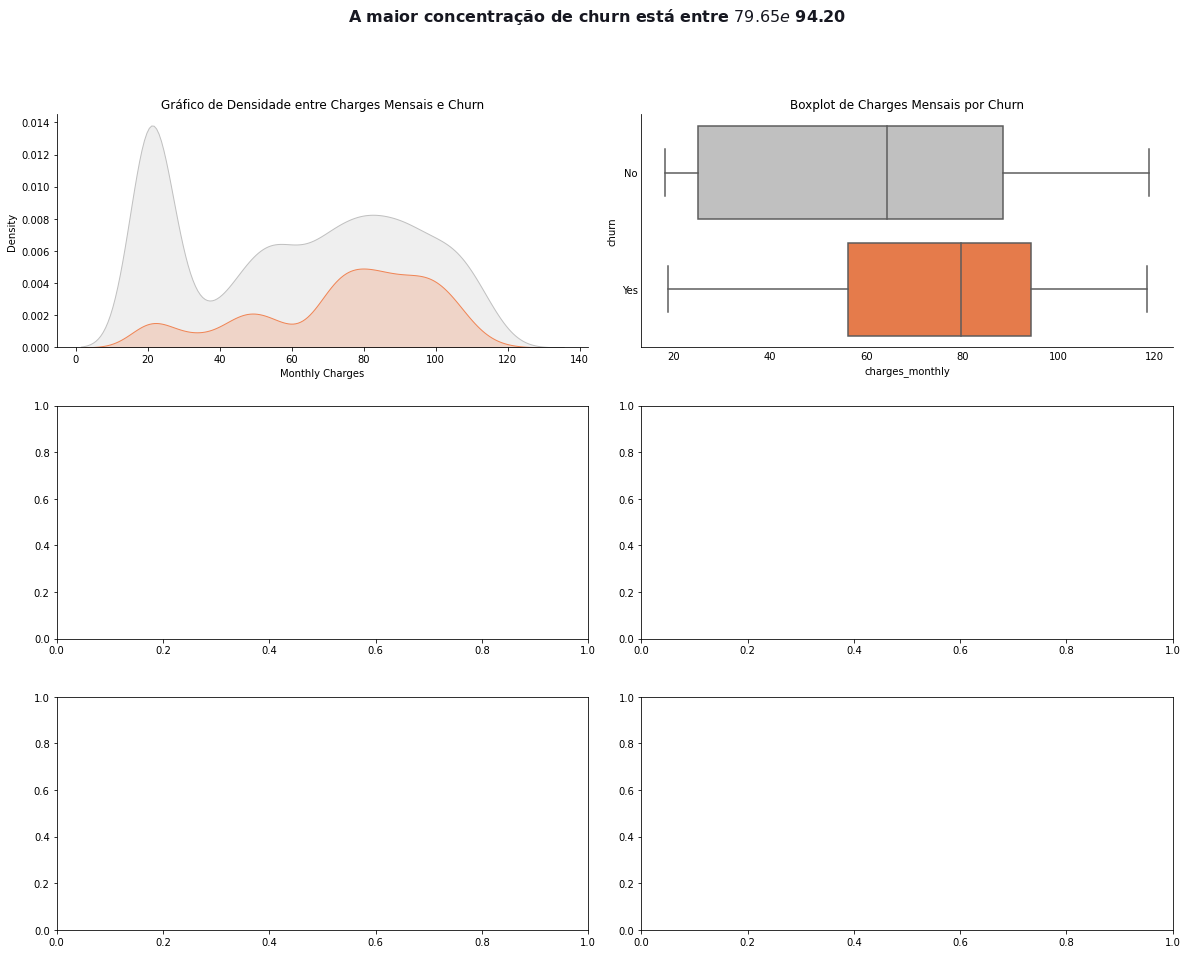

In [59]:
col = 'charges_monthly'

# Criar a matriz de gráficos
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
# fig.subplots_adjust(top=0.8)
fig.subplots_adjust(hspace=0.25, wspace=0.1)

formatted_text = ('A maior concentração de churn está entre $ {:.2f} e $ {:.2f}'.format(
    df_num_churn_yes[col].quantile(.5), df_num_churn_yes[col].quantile(.75)))

fig.suptitle(formatted_text, color=paleta_personalizada['black'], 
             fontsize=16, fontweight='bold')

# Definir a paleta personalizada
paleta_personalizada2 = {'No': 'silver', 'Yes': paleta_personalizada['orange']}

# Atribua a paleta personalizada
sns.set_palette(paleta_personalizada2.values())

# Criar um gráfico de densidade 
sns.kdeplot(data=df4, x=col, hue='churn', fill=True, ax=axs[0, 0])
axs[0, 0].set_xlabel('Monthly Charges')
axs[0, 0].set_ylabel('Density')
axs[0, 0].set_title('Gráfico de Densidade entre Charges Mensais e Churn')
axs[0, 0].legend(title='Churn', labels=[]).set_visible(False)
axs[0, 0].spines[['top', 'right']].set_visible(False)

# Criar um gráfico de densidade 
sns.boxplot(data=df4, x=col, y='churn', orient='h', ax=axs[0,1])
axs[0, 1].set_title('Boxplot de Charges Mensais por Churn')
axs[0, 1].legend(title='Churn', labels=[]).set_visible(False)
axs[0, 1].spines[['top', 'right']].set_visible(False)
axs[0, 1].tick_params(axis='both', which='both', length=0)

plt.show()

<Axes: xlabel='churn', ylabel='charges_monthly'>

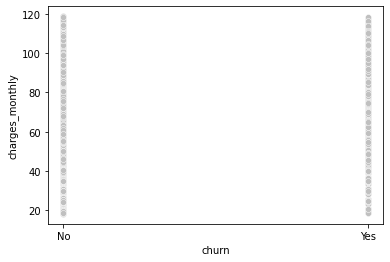

In [60]:
import seaborn as sns

sns.scatterplot(x='churn', y=col, data=df4)


In [61]:
col = 'churn'

aux = df4[col].value_counts(normalize=True).to_frame() * 100
aux = aux.sort_values(col, ascending=False)

cores = [paleta_personalizada['orange'] if tipo == aux[col].idxmin() else 
         paleta_personalizada['black'] for tipo in aux.index]

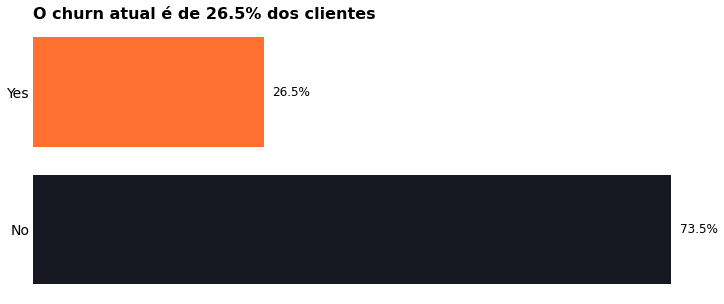

In [62]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(aux.index, aux[col], color=cores)

ax.yaxis.set_tick_params(labelsize=14)
ax.set_title(f'O churn atual é de {aux[col].min():.1f}% dos clientes', 
             loc='left', fontsize=16, fontweight='bold')

for i, v in enumerate(aux[col]):
    formatted_value = '{:.1f}%'.format(v)
    ax.text(v + 1, i, formatted_value, color='black', fontsize=12, ha='left', va='center')
    
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

plt.show()

### 4.2.2. Categorical Variable

## 4.3. Análise Multivariada

* Como as variáveis estão correlacionadas?
* Qual a força de correlação entre elas?
* Identificar e remover colunas que carregam o mesmo conteúdo de informação.

👉 É sempre bom lembrar que correlação não implica causalidade, só pq as variáveis estão correlacionadas não necessariamente uma causa a outra.

### 4.3.1. Numerical Attributes

In [63]:
df4_encoded = df4.copy()

In [64]:
df4.columns

Index(['churn', 'gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'charges_monthly', 'charges_total', 'num_services'],
      dtype='object')

In [65]:
df4_encoded.head()

,churn,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,charges_monthly,charges_total,num_services
0,No,Female,No,Yes,Yes,9,Yes,No,DSL,No,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,5
1,No,Male,No,No,No,9,Yes,Yes,DSL,No,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,4
2,Yes,Male,No,No,No,4,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,3
3,Yes,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,6
4,Yes,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,4


In [66]:
encode_columns = ['churn', 'gender', 'senior_citizen', 'partner', 'dependents',
                  'phone_service', 'multiple_lines', 'online_security', 'online_backup', 
                  'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 
                  'paperless_billing']

for col in encode_columns:
    df4_encoded[col] = df4_encoded[col].map(lambda x: 1 if x == 'Yes' else 0)

In [67]:
df4_encoded['streaming_movies'] = df4_encoded['streaming_movies'].map(lambda x: 1 if x == 'Yes' else 0)
df4_encoded['streaming_movies'].unique()

array([0], dtype=int64)

C:\Users\paula\AppData\Local\Temp\ipykernel_5948\1040768651.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
C:\Users\paula\AppData\Local\Temp\ipykernel_5948\1040768651.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)


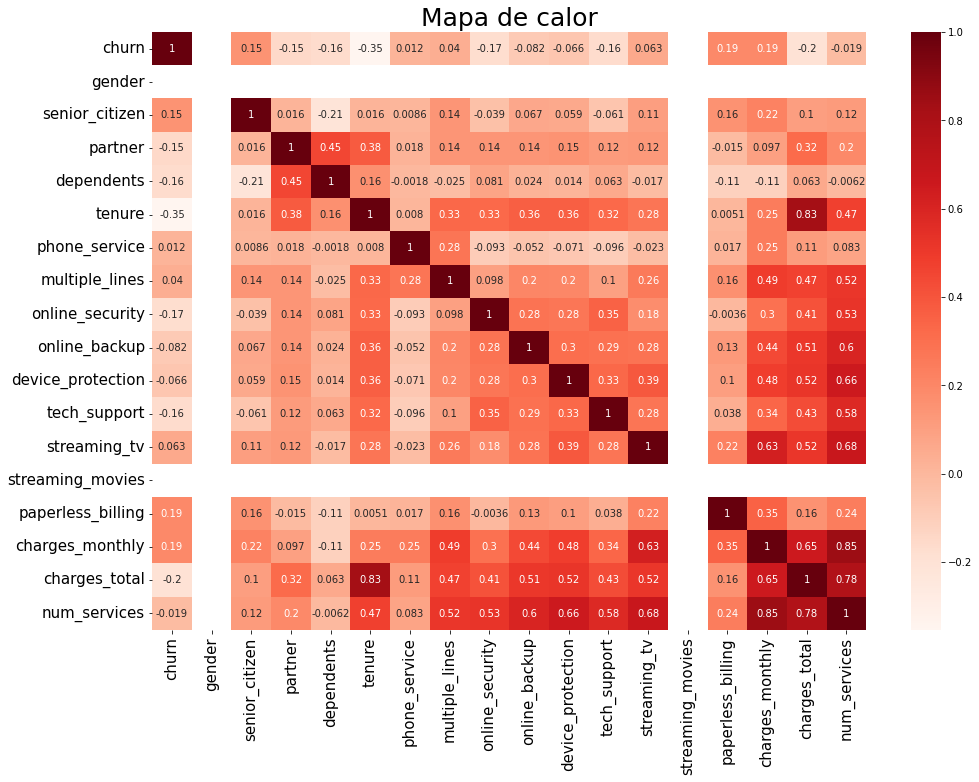

In [68]:
# Criar o mapa de calor
corr = df4_encoded.corr(method='pearson')
fig, ax = plt.subplots(figsize=(16, 11))

# Configura o título e os eixos
ax.set_title('Mapa de calor', fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)

# Plota e mostra o gráfico
ax = sns.heatmap(corr, annot=True, cmap='Reds', ax=ax)
plt.show()

In [69]:
# Avaliar o coeficiente de correlação

### 4.3.2. Categorical Attributes

In [70]:
a = df4_encoded[['internet_service', 'contract', 'payment_method']]
a.head()

,internet_service,contract,payment_method
0,DSL,One year,Mailed check
1,DSL,Month-to-month,Mailed check
2,Fiber optic,Month-to-month,Electronic check
3,Fiber optic,Month-to-month,Electronic check
4,Fiber optic,Month-to-month,Mailed check


In [71]:
from scipy                 import stats as ss

# Função para fazer o heatmap de variáveis categóricas
def cramer_v( x, y ):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / (min (kcorr-1, rcorr-1)) )

<Axes: >

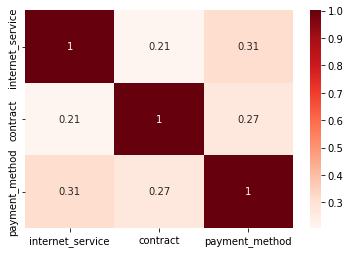

In [72]:
# Análise de correlação entre as variáveis
# --> Comprova que existe uma correlação forte entre 'assortment' e 'store_type'

# Apenas variáveis categóricos
# Calcular V de Cramer
a1 = cramer_v(a['internet_service'], a['internet_service'])
a2 = cramer_v(a['internet_service'], a['contract'])
a3 = cramer_v(a['internet_service'], a['payment_method'])

a4 = cramer_v(a['contract'], a['internet_service'])
a5 = cramer_v(a['contract'], a['contract'])
a6 = cramer_v(a['contract'], a['payment_method'])

a7 = cramer_v(a['payment_method'], a['internet_service'])
a8 = cramer_v(a['payment_method'], a['contract'])
a9 = cramer_v(a['payment_method'], a['payment_method'])

#Final dataset
d = pd.DataFrame({'internet_service': [a1, a2, a3],
                  'contract': [a4, a5, a6],
                  'payment_method': [a7, a8, a9]})
d = d.set_index(d.columns)

# Mostra o gráfico
sns.heatmap (d, annot=True, cmap='Reds')

# 5. DATA PREPARATION

In [107]:
df5 = df4.copy()

In [108]:
service_columns = ['phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 
                  'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

In [109]:
df5.drop(service_columns, axis=1, inplace=True)

## 5.3. Transformação

### 5.3.1. Encoding

In [110]:
encode_columns = ['churn', 'senior_citizen', 'partner', 'dependents',
                  'paperless_billing']

for col in encode_columns:
    df5[col] = df5[col].map(lambda x: 1 if x == 'Yes' else 0)
    
df5['gender'] = df5['gender'].map(lambda x: 1 if x == 'Male' else 0)

In [111]:
df5.head()

,churn,gender,senior_citizen,partner,dependents,tenure,contract,paperless_billing,payment_method,charges_monthly,charges_total,num_services
0,0,0,0,1,1,9,One year,1,Mailed check,65.6,593.30,5
1,0,1,0,0,0,9,Month-to-month,0,Mailed check,59.9,542.40,4
2,1,1,0,0,0,4,Month-to-month,1,Electronic check,73.9,280.85,3
3,1,1,1,1,0,13,Month-to-month,1,Electronic check,98.0,1237.85,6
4,1,0,1,1,0,3,Month-to-month,1,Mailed check,83.9,267.40,4


In [112]:
# One Hot Encoding
dummies_columns = ['contract', 'payment_method']

for col in dummies_columns:
    df5 = pd.get_dummies(df5, prefix=[col], columns=[col])

In [113]:
pd.set_option('display.max_columns', 17)
df5.head()

,churn,gender,senior_citizen,partner,dependents,tenure,paperless_billing,charges_monthly,charges_total,num_services,contract_Month-to-month,contract_One year,contract_Two year,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check
0,0,0,0,1,1,9,1,65.6,593.30,5,0,1,0,0,0,0,1
1,0,1,0,0,0,9,0,59.9,542.40,4,1,0,0,0,0,0,1
2,1,1,0,0,0,4,1,73.9,280.85,3,1,0,0,0,0,1,0
3,1,1,1,1,0,13,1,98.0,1237.85,6,1,0,0,0,0,1,0
4,1,0,1,1,0,3,1,83.9,267.40,4,1,0,0,0,0,0,1


# 6. FEATURE SELECTION

In [80]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [81]:
from sklearn.model_selection import StratifiedShuffleSplit

# 1. Separar dados de forma estratificada
X = df6.drop('churn', axis=1).values
y = df6['churn'].values

validador = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=44)
for treino_id, teste_id in validador.split(X, y):
    X_train, X_test = X[treino_id], X[teste_id]
    y_train, y_test = y[treino_id], y[teste_id]
    
# 2. Criar um modelo de classificação (Random Forest)
rf = RandomForestClassifier(n_estimators=100, random_state=44)

## 6.2. Boruta as feature selector

In [82]:
%%time
# Criar a instância do BorutaPy
#boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=44)

# Ajustar o BorutaPy aos dados
#boruta_selector.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [83]:
# Colunas selecionadas
#selected_columns = df6.drop('churn', axis=1).columns[boruta_selector.support_]
#print("Colunas Selecionadas:")
#print(selected_columns)

In [84]:
# Ranking de importância das colunas
#feature_ranking = boruta_selector.ranking_

# Crie um DataFrame apenas com as colunas selecionadas e seus rankings
#ranking_df = pd.DataFrame({'Feature': list(df6.drop('churn', axis=1).columns), 'Ranking': feature_ranking})

# Ordene o DataFrame pelo ranking
#ranking_df = ranking_df.sort_values(by='Ranking')

# Imprima o DataFrame
#print("Ranking de Importância das Colunas:")
#print(ranking_df)

## 6.4. Feature selector

In [115]:
import numpy as np
import pandas as pd
from   ydata_profiling import ProfileReport

profile = ProfileReport(df5, minimal=False)
profile = df5.profile_report(
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": True},
        "cramers": {"calculate": True},
        "phi_k": {"calculate": False},
    },
)

profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 6.3. Manual Feature Selection

In [85]:
#cols_selected_boruta = ['tenure', 'charges_monthly', 'charges_total']

# Adicionar colunas
#feat_to_add = ['num_services']

# Features final
#cols_selected_boruta_full = cols_selected_boruta.copy()
#cols_selected_boruta_full.extend( feat_to_add )

# 7. MACHINE LEARNING MODELING

## 7.1. Separar os dados

In [86]:
# from sklearn.model_selection import StratifiedShuffleSplit

# Separar dados em treino e teste de forma estratificada
def executar_validador(X, y):
    validador = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
    for treino_id, teste_id in validador.split(X, y):
        X_train, X_test = X[treino_id], X[teste_id]
        y_train, y_test = y[treino_id], y[teste_id]
    return X_train, X_test, y_train, y_test

In [87]:
%%time
X = df5.drop('churn', axis=1).values
y = df5['churn'].values

# executar validador
X_train, X_test, y_train, y_test = executar_validador(X, y)

CPU times: total: 15.6 ms
Wall time: 17.7 ms


## 7.2. Treino, teste e validação

### 7.2.1. Baseline: Decision Tree Classifier

In [91]:
from sklearn import tree
# Treino e teste
def executar_classificador(classificador, X_train, X_test, y_train):
    arvore = classificador.fit(X_train, y_train)
    y_pred = arvore.predict(X_test)
    return y_pred

In [89]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def validar_arvore(y_test, y_pred):
    print(accuracy_score(y_test, y_pred))
    print(precision_score(y_test, y_pred))
    print(recall_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

In [92]:
# execucao do classificador DecisionTreeClassifier
classificador_arvore_decisao = tree.DecisionTreeClassifier(max_depth=10, random_state=44)
y_pred_arvore_decisao = executar_classificador(classificador_arvore_decisao, X_train, X_test, y_train)

In [93]:
# validacao arvore de decisao
validar_arvore(y_test, y_pred_arvore_decisao)

0.7730496453900709
0.576271186440678
0.5454545454545454
[[443  75]
 [ 85 102]]


### 7.2.2. Random Forest Classifier

In [94]:
%%time
from sklearn.ensemble import RandomForestClassifier

classificador_random_forest = RandomForestClassifier(n_estimators=100, random_state=0)
y_pred_random_forest = executar_classificador(classificador_random_forest, X_train, X_test, y_train)

CPU times: total: 844 ms
Wall time: 1.89 s


In [95]:
validar_arvore(y_test, y_pred_random_forest)

0.7900709219858156
0.6423357664233577
0.47058823529411764
[[469  49]
 [ 99  88]]


In [96]:
# Exiba os parâmetros
print(classificador_arvore_decisao.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 44, 'splitter': 'best'}


In [97]:
%%time
from sklearn.ensemble import RandomForestClassifier

classificador_random_forest = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=10)
y_pred_random_forest = executar_classificador(classificador_random_forest, X_train, X_test, y_train)

CPU times: total: 562 ms
Wall time: 753 ms


In [98]:
validar_arvore(y_test, y_pred_random_forest)

0.8028368794326242
0.6690140845070423
0.5080213903743316
[[471  47]
 [ 92  95]]


### 7.2.3. Adaboost

In [99]:
%%time
from sklearn.ensemble import AdaBoostClassifier

classificador_adaboost = AdaBoostClassifier(n_estimators=100, random_state=0)
y_pred_adaboost = executar_classificador(classificador_adaboost, X_train, X_test, y_train)

CPU times: total: 719 ms
Wall time: 1.62 s


In [100]:
#validacao arvore de decisao
validar_arvore(y_test, y_pred_adaboost)

0.8141843971631205
0.6842105263157895
0.5561497326203209
[[470  48]
 [ 83 104]]
